In [ ]:
install.packages('data.table', quiet = TRUE)
install.packages('e1071', quiet = TRUE)
install.packages('MASS', quiet = TRUE)
install.packages('mda', quiet = TRUE)

also installing the dependency ‘proxy’




In [ ]:
library(data.table)
library(e1071)
library(MASS)
library(mda)

options(warn=-1)

Loading required package: class

Loaded mda 0.5-2




# SVM


## Motivation
The math behind the Support Vector Machine (SVM) is relatively complicated. However, the original motivation is quite intuitive. In short, one attempts to utilize a combination of two ideas - finding a linearly separating hyperplane for the data (LDA, K-means) and enlarging the feature space (QDA).




## Support Vector Classifier
Let's begin by specifying the problem. We start with some data $x_i \in R^p$, $y_i \in \{-1, 1\}$. That is, binary classification in $p$ dimensions. We define a hyperplane as $$\{x : f(x) = x^T \beta + \beta_0\ = 0\}$$ and the corresponding classifier $$G(x) = sign(f(x)) = sign(x^T \beta +\beta_0)$$ So put simply, if points are "below" a hyperplane, we classify them as $-1$, and $1$ when they're "above". Now, assuming there exists a plane which separates **all** points, there must be a set of $\beta$ s.t. $y_i f(x_i) > 0, \forall i$. That allows us to further optimize demanding the **margin** (distance) of separation is maximized. This is done by writing it as $$\max M, ||\beta|| = 1$$, while $$y_i(x^T_i \beta + \beta_0) \geq M, \forall i$$

Now, in general, when that is impossible, the clever trick is to still "attempt" to maximize the margin, but allow some "slack" for it, that is $$y_i(x^T_i \beta + \beta_0) \geq M (1 - \xi_i), \xi_i \geq 0$$, $$ \sum_i \xi_i \leq const$$. Since we allow $\xi_i > 1$, some points might be "missclassified" by our hyperplane, but not too many and not by much (exactly how many and how much is controlled by $const$).

After some complicated math in ESL, one can transform this problem into a constrained dual Lagrangian form:
$$ L_D = \sum_i \alpha_i -1/2 \sum_i \sum_{i'} \alpha_i \alpha_{i'} y_i y_{i'} (x^T_i  x_{i'}) $$, where the dot product between $x_i$ and $x_i'$ is emphasized. Finally, one can show that $$\hat{f}(x) = x^T \hat{\beta} + \beta_0 = \sum_i \alpha_i y_i (x^T x_i) + \beta_0$$. Notice that due to certain inequality constraints, only a handful of points (*support vectors*) will contribute to this sum - points which are either missclassified or "weakly" classified, i.e. within a margin $$ y_i (x_i^T \beta + \beta_0) \leq 1$$

Now the critical observation is that in both formulas above **only** the dot products appear. It means that if one enlarges the feature space into a $q$-dimensional one, $q > p$, $h(x) \in R^q$, upon repeating the same calculation, the only thing to pop out would be the evaluations of the Kernel:
$$K(x, x') = \langle h(x), h(x')\rangle$$
Thus, we achieve two goals simultaneously - we enlarge the feature space but restrict the dependence of the classifier on the features $h_j(x), j =1,..q$, thus achieving some regularization.




$$f(x) = x^2 + y^2, g(x) = x + y - 1$$
$$L = x^2 + y^2 + \lambda * g(x)$$
$$ 2x + \lambda * x = 0$$
$$ 2y + \lambda *y = 0$$
$$ x + y - 1 = 0$$

## Example: linearly separable data

In [ ]:
class_1 <- data.frame(mvrnorm(100, c(-3,-3), matrix(c(1,0,0,1), nrow=2)))
class_2 <- data.frame(mvrnorm(100, c(3,3), matrix(c(1,0,0,1), nrow=2)))
class_1$label <- -1
class_2$label <- 1
lin_data <- rbind(class_1, class_2)
lin_data$label = factor(lin_data$label)
head(lin_data)

,X1,X2,label
,<dbl>,<dbl>,<fct>
1,-1.772489,-4.2372861,-1
2,-3.802610,-4.6037960,-1
3,-2.145526,-2.3296993,-1
4,-2.456748,-0.8989331,-1
5,-3.093169,-2.1368323,-1
6,-3.029635,-1.6485988,-1


In [ ]:
svm_lin = svm(label ~ X1 + X2, data = lin_data, kernel = 'linear',
  type = 'C-classification', scale = FALSE)

svm_lin


Call:
svm(formula = label ~ X1 + X2, data = lin_data, kernel = "linear", 
    type = "C-classification", scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  2


In [ ]:
plot_svm_util = function(svm_fit, data){
  plot(svm_fit, data, X2 ~ X1, fill = FALSE)
  print(head(svm_fit$SV))
  print(paste0(dim(svm_fit$SV)[1], " support vectors"))
  (cf <- coef(svm_fit))
  print(c('coefs: ', cf))
#plot decision boundary
  abline(-cf[1]/cf[3], -cf[2]/cf[3], col = "red")
# plot margin
  abline(-(cf[1] + 1)/cf[3], -cf[2]/cf[3], col = "blue")
  abline(-(cf[1] - 1)/cf[3], -cf[2]/cf[3], col = "blue")
}

            X1         X2
44  -0.7141077 -1.1479906
198  1.7490903  0.4255811
[1] "2 support vectors"
                              (Intercept)                   X1 
           "coefs: "  "0.165343060586461" "-0.576626908895458" 
                  X2 
"-0.368368183811751" 


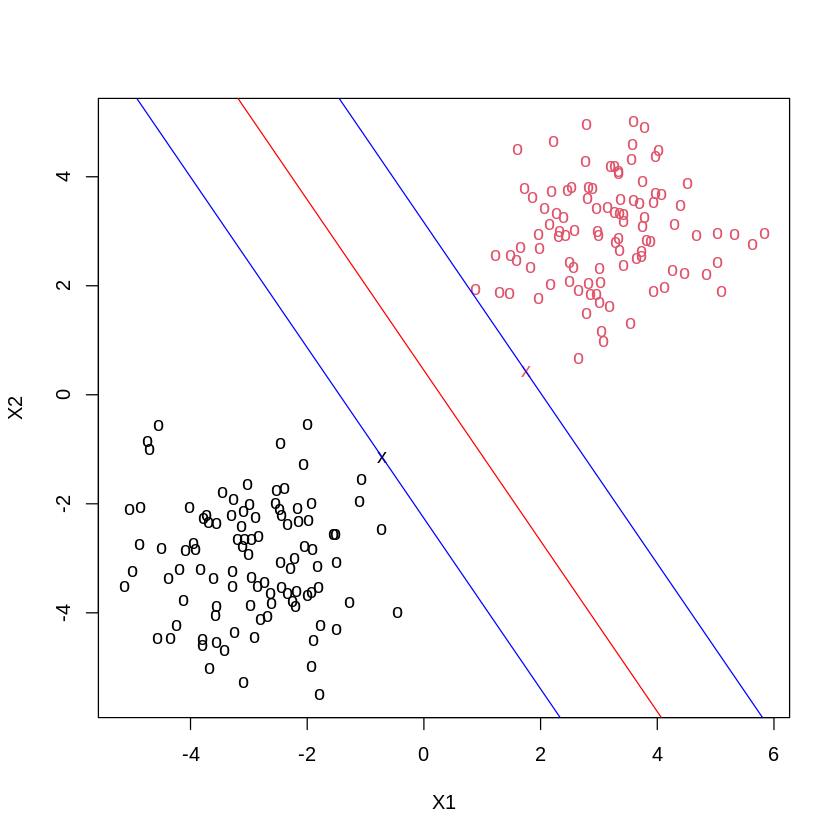

In [ ]:
plot_svm_util(svm_lin, lin_data)

support vectors lie **exactly** on margin

## Non-separable data
Let's spoil separability

In [ ]:
class_1 <- data.frame(mvrnorm(100, c(-1,-1), matrix(c(1,0,0,1), nrow=2)))
class_2 <- data.frame(mvrnorm(100, c(1,1), matrix(c(1,0,0,1), nrow=2)))
class_1$label <- -1
class_2$label <- 1
lin_data <- rbind(class_1, class_2)
lin_data$label = factor(lin_data$label)
head(lin_data)

,X1,X2,label
,<dbl>,<dbl>,<fct>
1,-1.2003334,0.2281023,-1
2,-1.5250641,-0.7600925,-1
3,-1.1068105,-0.2935772,-1
4,-1.4381392,-1.8255092,-1
5,1.1803655,-1.0129967,-1
6,-0.1110474,-0.7971031,-1


In [ ]:
svm_list = list()
svm_lin = svm(label ~ X1 + X2, data = lin_data, kernel = 'linear',
  type = 'C-classification', scale = FALSE)
svm_list = c(svm_list, list(svm_lin))

            X1         X2
5   1.18036548 -1.0129967
12  1.08361457 -1.4455183
14 -0.08421565 -0.1116507
16 -0.36387020  0.1485351
18 -0.44035344 -0.1649751
25 -0.38186157  0.2899962
[1] "40 support vectors"
                              (Intercept)                   X1 
           "coefs: " "0.0718847252705863"  "-1.12903752413193" 
                  X2 
 "-1.48625171924095" 


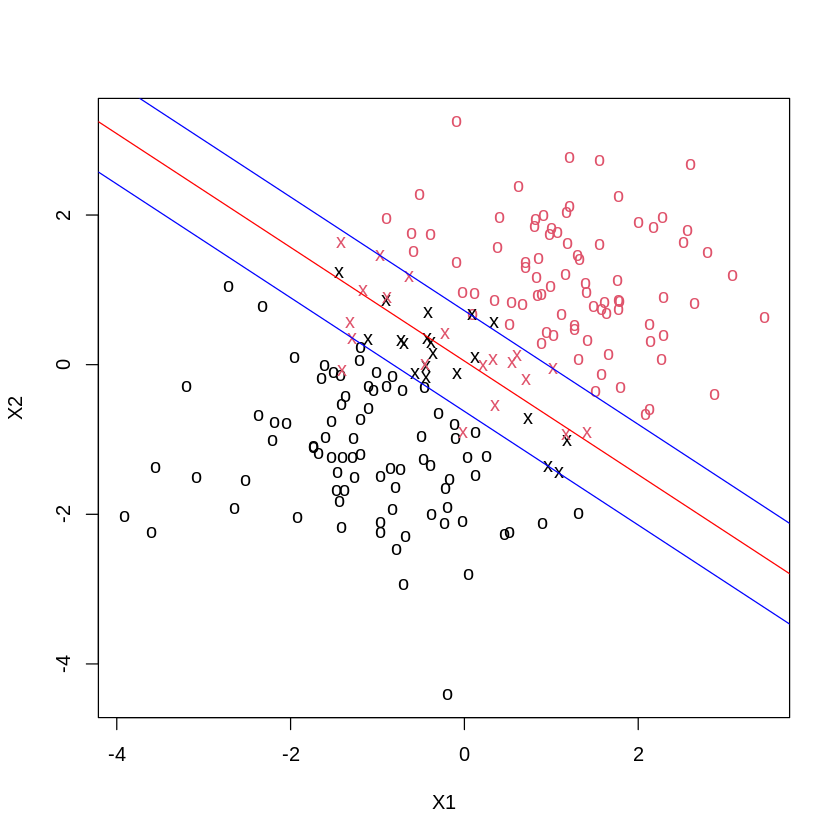

In [ ]:
plot_svm_util(svm_lin, lin_data)

Now we have a whole bunch of support vectors (labeled by crosses)

In [ ]:
svm_lin = svm(label ~ X1 + X2, data = lin_data, kernel = 'linear',
  type = 'C-classification', scale = FALSE, cost = 0.01)
svm_lin
svm_list = c(svm_list, list(svm_lin))


Call:
svm(formula = label ~ X1 + X2, data = lin_data, kernel = "linear", 
    type = "C-classification", cost = 0.01, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  0.01 

Number of Support Vectors:  108


          X1         X2
1 -1.2003334  0.2281023
3 -1.1068105 -0.2935772
5  1.1803655 -1.0129967
6 -0.1110474 -0.7971031
7 -2.7087233  1.0473999
8  0.5215674 -2.2387110
[1] "108 support vectors"
                              (Intercept)                   X1 
           "coefs: " "0.0474146769876543" "-0.481413834277816" 
                  X2 
"-0.516859734006282" 


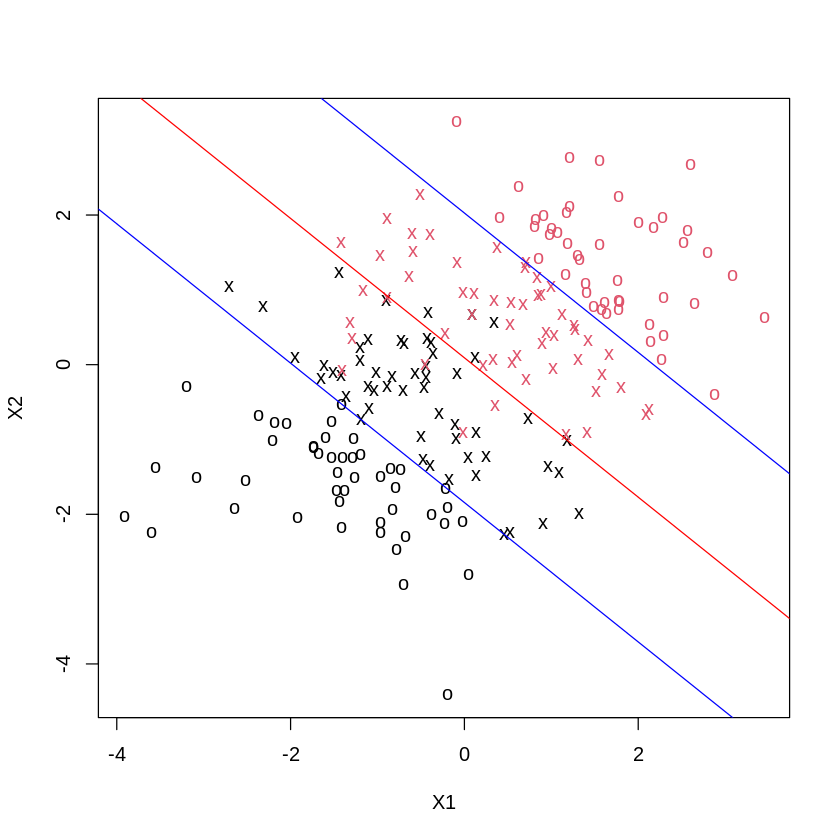

In [ ]:
plot_svm_util(svm_lin, lin_data)

In [ ]:
svm_lin = svm(label ~ X1 + X2, data = lin_data, kernel = 'linear',
  type = 'C-classification', scale = FALSE, cost = 1e3)
svm_lin
svm_list = c(svm_list, list(svm_lin))


Call:
svm(formula = label ~ X1 + X2, data = lin_data, kernel = "linear", 
    type = "C-classification", cost = 1000, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1000 

Number of Support Vectors:  37


            X1         X2
5   1.18036548 -1.0129967
12  1.08361457 -1.4455183
14 -0.08421565 -0.1116507
16 -0.36387020  0.1485351
18 -0.44035344 -0.1649751
25 -0.38186157  0.2899962
[1] "37 support vectors"
                              (Intercept)                   X1 
           "coefs: " "0.0745274836899845"   "-1.3336558008704" 
                  X2 
 "-1.62933574423221" 


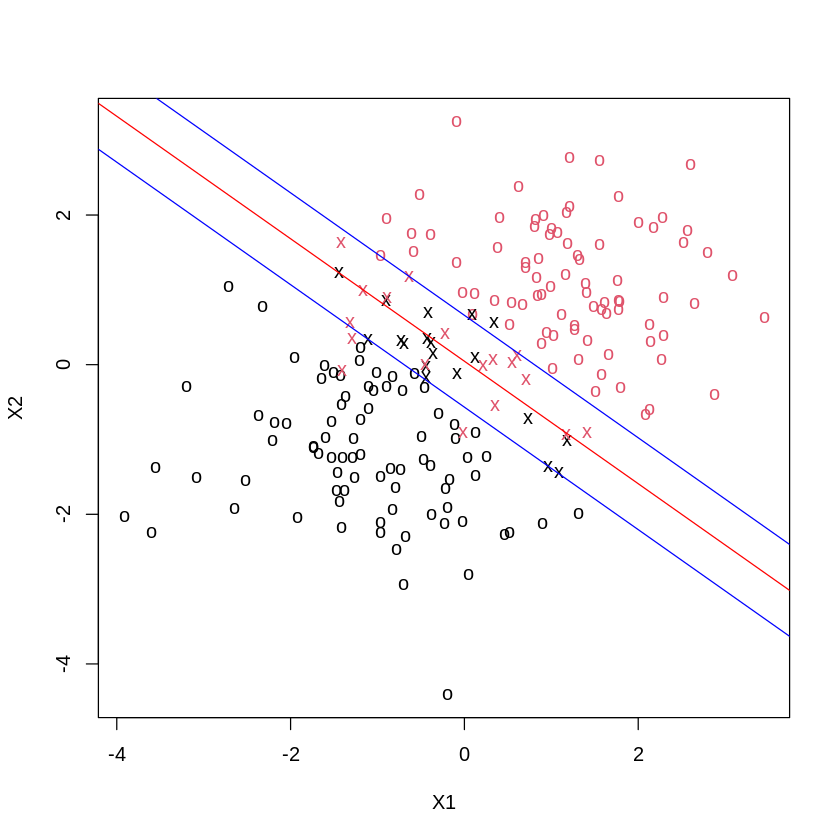

In [ ]:
plot_svm_util(svm_lin, lin_data)

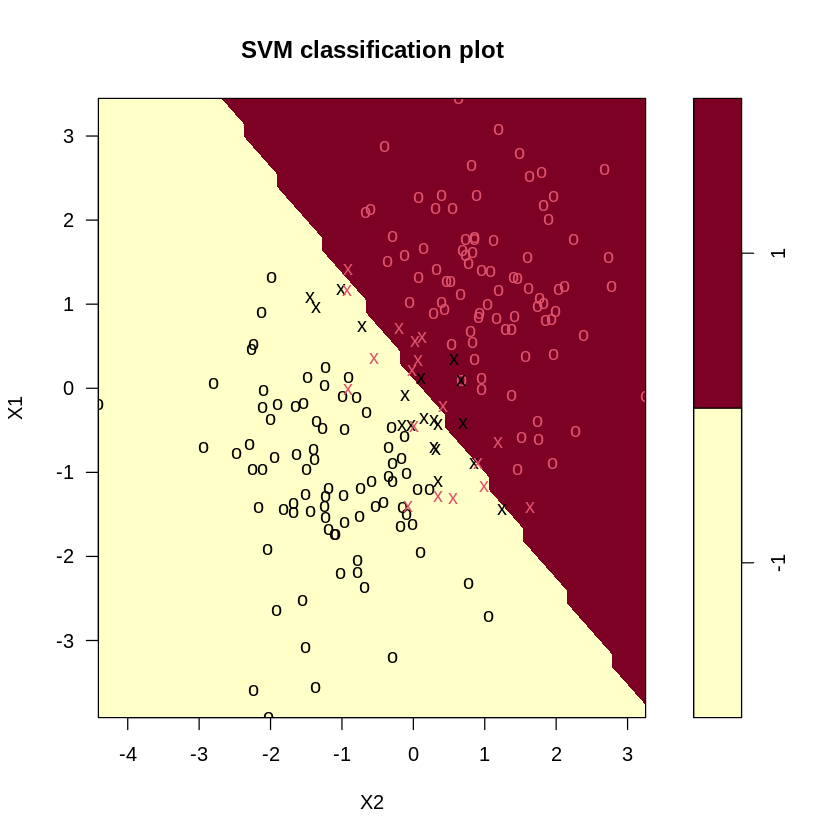

In [ ]:
plot(svm_lin, lin_data)

Notice the margin widens with decreased cost constant and vice-versa.



## Separable in quadratic variables

,X1,X2,label
,<dbl>,<dbl>,<fct>
1,-0.8509503,-0.34309092,-1
2,0.7829013,0.38399209,-1
3,-0.3344100,0.10510437,-1
4,-0.8898860,-0.04751376,-1
5,-0.4568490,0.02309717,-1
6,0.2372198,0.33311411,-1


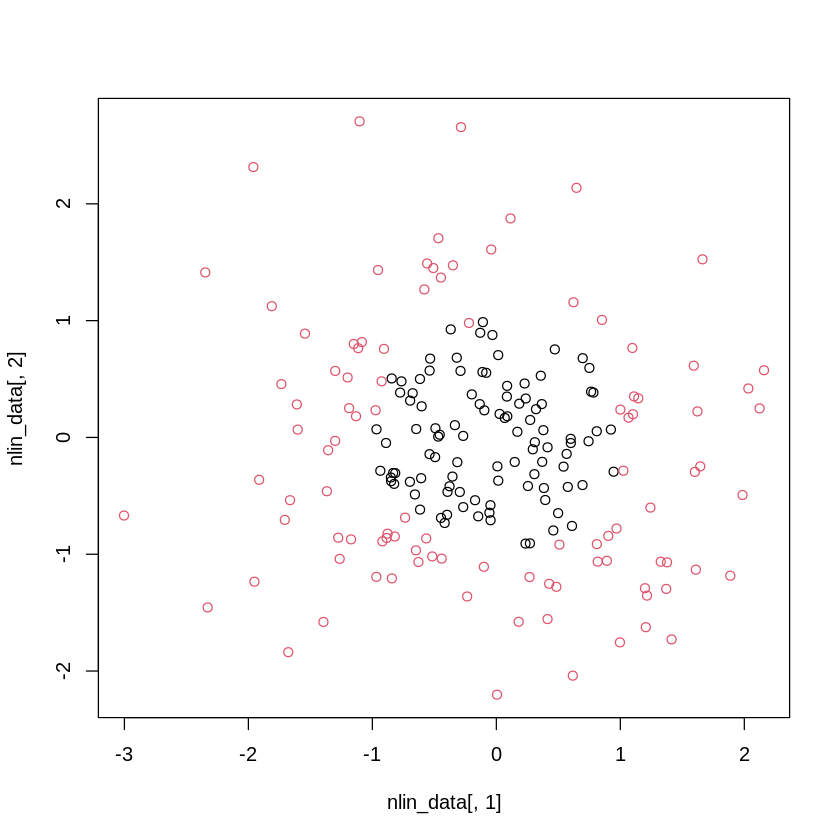

In [ ]:
#class_1 <- data.frame(mvrnorm(100, c(0,0), matrix(c(1,0,0,1), nrow=2)))
class_1 <- data.frame(X1 = rep(0, 100), X2 = rep(0,100))
i = 1
while(i < 101){
  tmp_x = mvrnorm(1, c(0,0), matrix(c(1,0,0,1), nrow=2))

  if(sum(tmp_x**2) < 1){

    class_1[i,] = tmp_x
    i = i +1
  }

}

class_2 <- data.frame(X1 = rep(0, 100), X2 = rep(0,100))
i = 1
while(i < 101){
  tmp_x = mvrnorm(1, c(0,0), matrix(c(1,0,0,1), nrow=2))

  if(sum(tmp_x**2) > 1){

    class_2[i,] = tmp_x
    i = i +1
  }

}

#class_2 <- data.frame(mvrnorm(100, c(3,3), matrix(c(1,0,0,1), nrow=2)))
class_1$label <- -1
class_2$label <- 1
nlin_data <- rbind(class_1, class_2)
nlin_data$label = factor(nlin_data$label)
head(nlin_data)

plot(nlin_data[, 1], nlin_data[, 2], col = nlin_data[,'label'])

In [ ]:
svm_nlin = svm(label ~ X1 + X2, data = nlin_data,
  type = 'C-classification', kernel = 'polynomial', degree = 2)

table(nlin_data$label, fitted(svm_nlin))
print(svm_nlin)

    
     -1  1
  -1 96  4
  1  10 90


Call:
svm(formula = label ~ X1 + X2, data = nlin_data, type = "C-classification", 
    kernel = "polynomial", degree = 2)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  polynomial 
       cost:  1 
     degree:  2 
     coef.0:  0 

Number of Support Vectors:  62



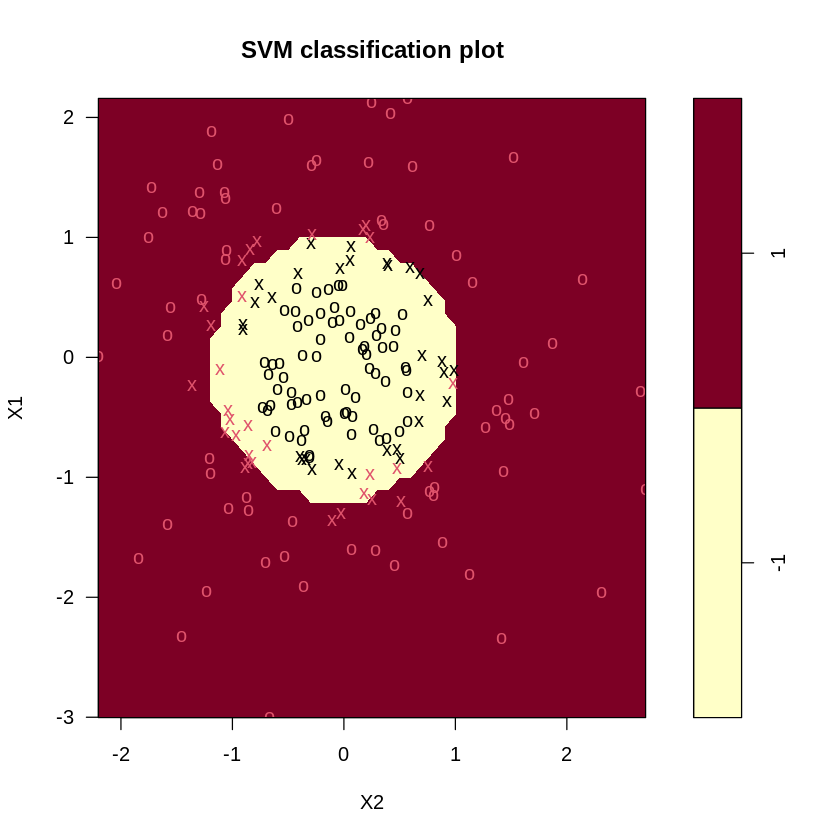

In [ ]:
plot(svm_nlin, nlin_data)

    
      -1   1
  -1 100   0
  1   23  77

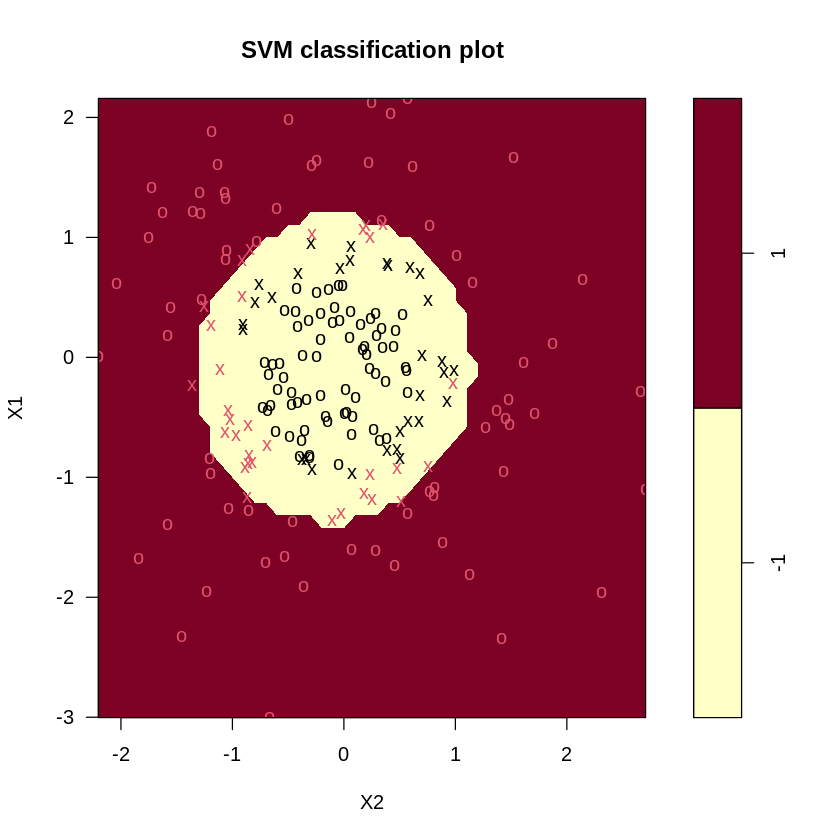

In [ ]:
svm_nlin = svm(label ~ X1 + X2, data = nlin_data,
  type = 'C-classification', kernel='polynomial', degree=10
)

table(nlin_data$label, fitted(svm_nlin))

plot(svm_nlin, nlin_data)

Separable in the space of the quadratic features induced by the kernel!

## More realistic data



In [ ]:
data(iris)

x <- iris[, -5]
y <- iris$Species
N = length(y)
idx = sample(1:N, round(0.7*N))
x_trn = x[idx, ]
y_trn = y[idx]
x_tst = x[-idx, ]
y_tst = y[-idx]

#model <- svm(x_trn, y_trn) ## default uses the radial, or RBF Kernel
model = svm(Species ~., data = iris[idx, ])
print(model)
summary(model)


Call:
svm(formula = Species ~ ., data = iris[idx, ])


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  44




Call:
svm(formula = Species ~ ., data = iris[idx, ])


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  44

 ( 8 18 18 )


Number of Classes:  3 

Levels: 
 setosa versicolor virginica




In [ ]:
table(fitted(model), y_trn)

            y_trn
             setosa versicolor virginica
  setosa         35          0         0
  versicolor      0         37         2
  virginica       0          1        30

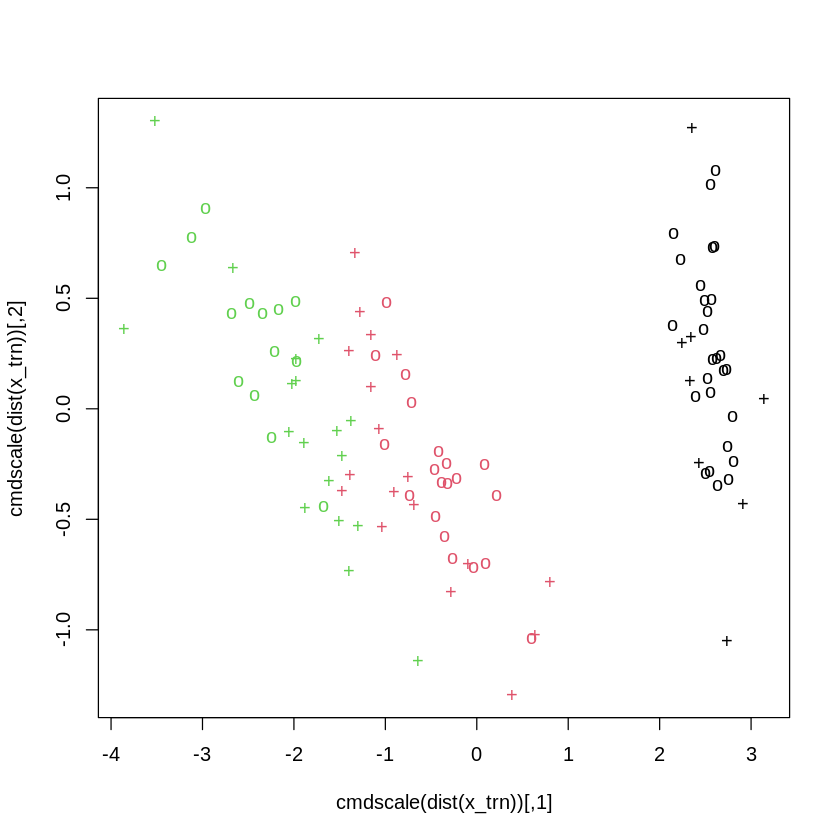

In [ ]:
plot(cmdscale(dist(x_trn)),
col = as.integer(y_trn),
pch = c("o","+")[1:length(idx) %in% model$index + 1])

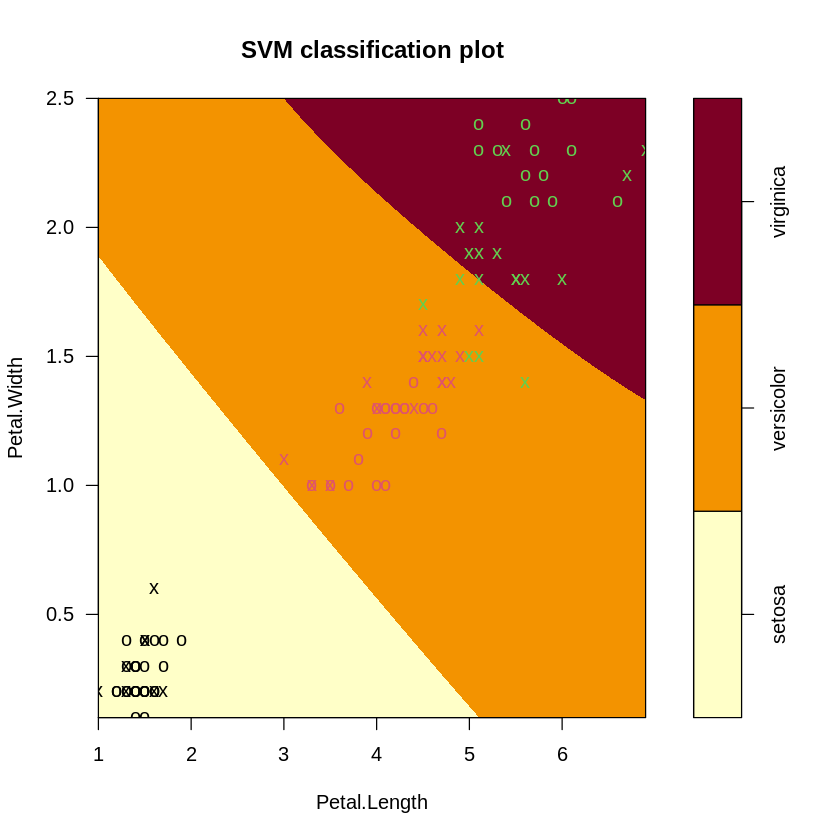

In [ ]:
plot(model, data = iris[idx, ], Petal.Width ~ Petal.Length,
  slice = list(Sepal.Width = 3, Sepal.Length = 4), grid = 5000)


K > 2 is typically handled by K*(K-1)/2 instances of one-vs-many classifiers

In [ ]:
table(predict(model, x_tst), y_tst)

            y_tst
             setosa versicolor virginica
  setosa         15          0         0
  versicolor      0         11         0
  virginica       0          1        18

In [ ]:
e1071:::plot.svm

function (x, data, formula = NULL, fill = TRUE, grid = 50, slice = list(), 
    symbolPalette = palette(), svSymbol = "x", dataSymbol = "o", 
    ...) 
{
    if (x$type < 3) {
        if (is.null(formula) && ncol(data) == 3) {
            formula <- formula(delete.response(terms(x)))
            formula[2:3] <- formula[[2]][2:3]
        }
        if (is.null(formula)) 
            stop("missing formula.")
        if (fill) {
            sub <- model.frame(formula, data)
            xr <- seq(min(sub[, 2]), max(sub[, 2]), length.out = grid)
            yr <- seq(min(sub[, 1]), max(sub[, 1]), length.out = grid)
            l <- length(slice)
            if (l < ncol(data) - 3) {
                slnames <- names(slice)
                slice <- c(slice, rep(list(0), ncol(data) - 3 - 
                  l))
                names <- labels(delete.response(terms(x)))
                names(slice) <- c(slnames, names[!names %in% 
                  c(colnames(sub), slnames)])
            }
            for (i in names(which(vapply(data, is.factor, NA)))) if (!is.factor(slice[[i]])) {
                levs <- levels(data[[i]])
                lev <- if (is.character(slice[[i]])) 
                  slice[[i]]
                else levs[1]
                fac <- factor(lev, levels = levs)
                if (is.na(fac)) 
                  stop(paste("Level", dQuote(lev), "could not be found in factor", 
                    sQuote(i)))
                slice[[i]] <- fac
            }
            lis <- c(list(yr), list(xr), slice)
            names(lis)[1:2] <- colnames(sub)
            new <- expand.grid(lis)[, labels(terms(x))]
            preds <- predict(x, new)
            filled.contour(xr, yr, matrix(as.numeric(preds), 
                nrow = length(xr), byrow = TRUE), plot.axes = {
                axis(1)
                axis(2)
                colind <- as.numeric(model.response(model.frame(x, 
                  data)))
                dat1 <- data[-x$index, ]
                dat2 <- data[x$index, ]
                coltmp1 <- symbolPalette[colind[-x$index]]
                coltmp2 <- symbolPalette[colind[x$index]]
                points(formula, data = dat1, pch = dataSymbol, 
                  col = coltmp1)
                points(formula, data = dat2, pch = svSymbol, 
                  col = coltmp2)
            }, levels = 1:(length(levels(preds)) + 1), key.axes = axis(4, 
                1:(length(levels(preds))) + 0.5, labels = levels(preds), 
                las = 3), plot.title = title(main = "SVM classification plot", 
                xlab = names(lis)[2], ylab = names(lis)[1]), 
                ...)
        }
        else {
            plot(formula, data = data, type = "n", ...)
            colind <- as.numeric(model.response(model.frame(x, 
                data)))
            dat1 <- data[-x$index, ]
            dat2 <- data[x$index, ]
            coltmp1 <- symbolPalette[colind[-x$index]]
            coltmp2 <- symbolPalette[colind[x$index]]
            points(formula, data = dat1, pch = dataSymbol, col = coltmp1)
            points(formula, data = dat2, pch = svSymbol, col = coltmp2)
            invisible()
        }
    }
}
<bytecode: 0x557a1d74fa48>
<environment: namespace:e1071>

In general, the parameters to tune are the cost parameter and the kernel, the functional form and the numerical parameters (degree for polynomial, width for radial, etc)

## Support vector regression
Can also be used for regression, under a suitable choice of a Loss function.
$$ L_{\epsilon}= 0, |x| < \epsilon,
L_{\epsilon} = |x| - \epsilon, |x| \geq \epsilon$$



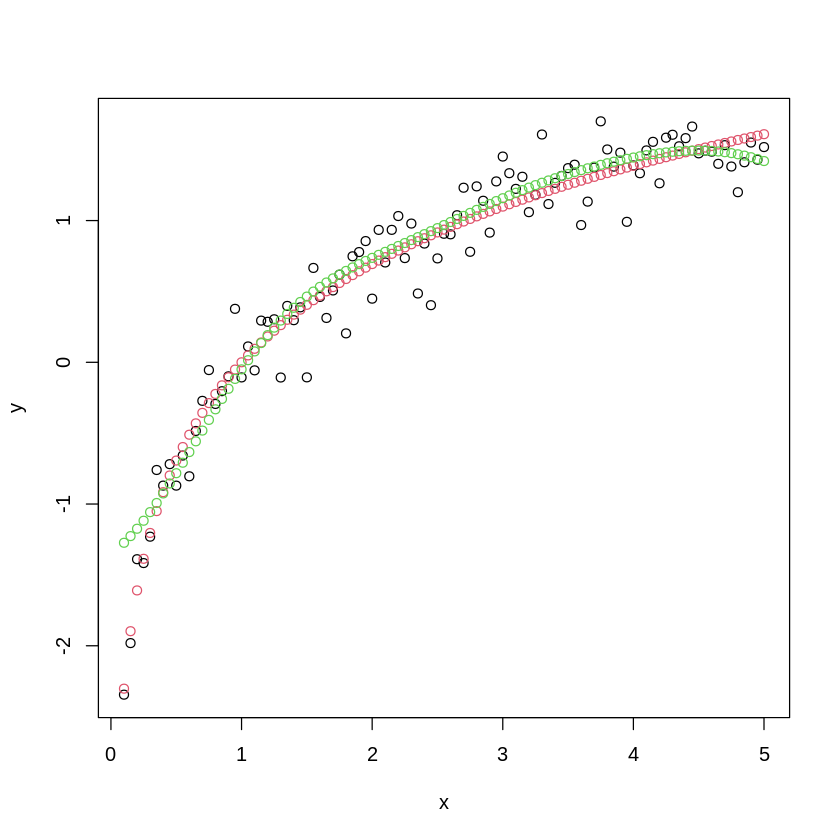

In [ ]:
x <- seq(0.1, 5, by = 0.05)
y <- log(x) + rnorm(x, sd = 0.2)
# estimate model and predict input values
m <- svm(x, y)
new <- predict(m, x)
# visualize
plot (x, y)
points (x, log(x), col = 2)
points(x, new, col = 3) ## sv regression


does a decent job approximating a log


In [ ]:
?svm

# Flexible discriminant analysis

In short, this a sophisticated trick to simultaneously enlarge the possible feature space from LDA to more general non-linear features, while fitting the discriminant function from a rich model set such as smooth splines or MARS.

In [ ]:
irisfit <- fda(Species ~ ., data = iris)
irisfit
confusion(irisfit, iris)

Call:
fda(formula = Species ~ ., data = iris)

Dimension: 2 

Percent Between-Group Variance Explained:
    v1     v2 
 99.12 100.00 

Degrees of Freedom (per dimension): 5 

Training Misclassification Error: 0.02 ( N = 150 )

            true
predicted    setosa versicolor virginica
  setosa         50          0         0
  versicolor      0         48         1
  virginica       0          2        49

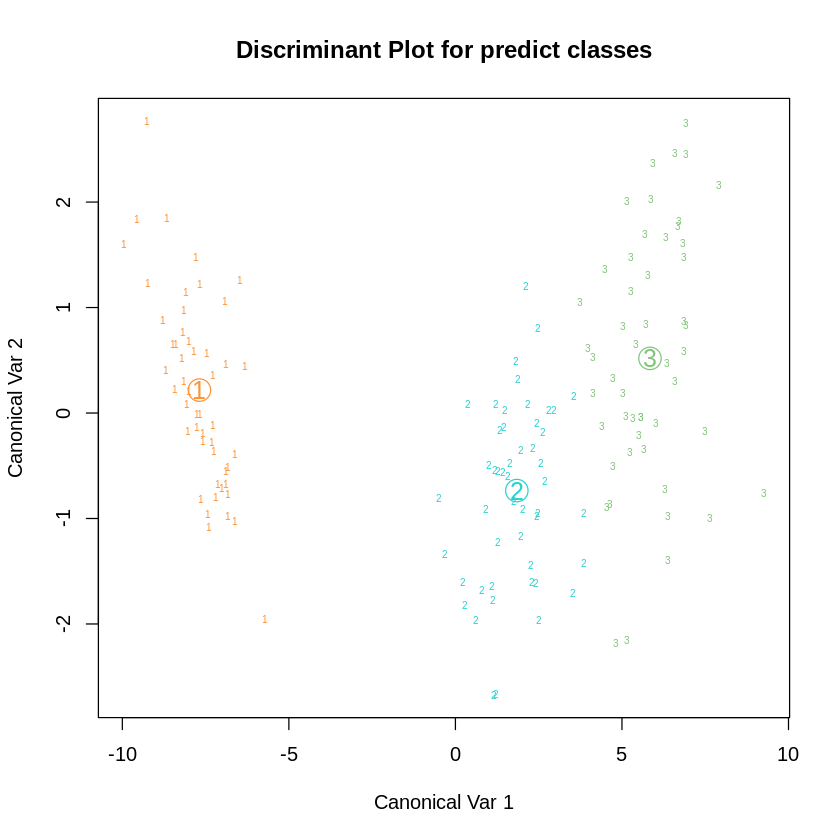

In [ ]:
plot(irisfit)

In [ ]:
marsfit <- fda(Species ~ ., data = iris, method = mars)
marsfit2 <- update(marsfit, degree = 2)
marsfit3 <- update(marsfit, theta = marsfit$means[, 1:2])

In [ ]:
confusion(marsfit3, iris)

            true
predicted    setosa versicolor virginica
  setosa         50          0         0
  versicolor      0         47         1
  virginica       0          3        49